**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
%matplotlib inline

import sys
import gc
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

**Import Data**

In [2]:
df = pd.read_csv('nct_dream_data.csv',encoding = 'utf-8-sig',parse_dates=['publishedAt'])

# Retrieve only year-month-day
df["publishedAt"]=pd.to_datetime(df["publishedAt"]).dt.date
#Rename column to show unit
df.rename({'subscriberCount': 'subscriberCountMillions'}, axis=1, inplace=True)

df.head()
df.dtypes

title                       object
publishedAt                 object
viewCount                    int64
likeCount                    int64
commentCount                 int64
duration                     int64
memberCount                float64
category                    object
keywords                    object
subscriberCountMillions    float64
dtype: object

# Data Wrangling

**Delete videos that are "Shorts"**

In [3]:
df=df[df['category']!="Shorts"]
print(f'df has {len(df)} rows after removing shorts')
df.reset_index(drop=True, inplace=True)


df has 348 rows after removing shorts


**Add the duration of days past since the data is collected**

In [4]:
# date_collected = '2022-11-26'.
# print(pd.Timestamp.today().date())
df['daysPassed'] = (pd.to_datetime('2022-11-26')-pd.to_datetime(df['publishedAt'])).dt.days.astype('int')


**Fill in empty data for Subscribers using fitting** <br>
Youtube API does not provide the number of subscribers by date. I have achieved 82 (or 6 months worth) of subscriber count data from third party. This data will be used for analysis and prediction of the previous empty data.

Text(0, 0.5, 'Subscribers(M)')

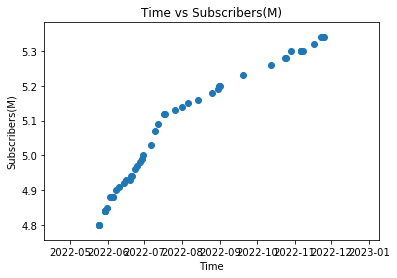

In [5]:
# Visualize non NAN columns for subscriberCount
df_sub= df[['publishedAt','subscriberCountMillions']]
df_sub = df_sub.dropna()
df_sub.reset_index(drop=True, inplace=True)

plt.scatter(df_sub['publishedAt'],df_sub['subscriberCountMillions'])
plt.title('Time vs Subscribers(M)')
plt.xlabel("Time")
plt.ylabel("Subscribers(M)")



From the plot, we can interpret that the number of subscribers are increasing. The increasing trend seems somewhat linear but also seems to concave downwards. <br>
We will fit this data to a logarithmic fit 

Text(0.5, 0, 'Time (Ordinal)')

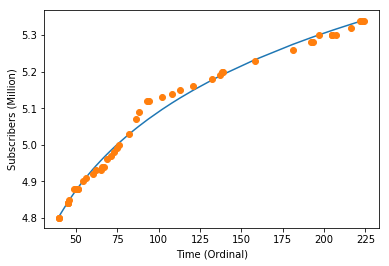

In [6]:
df_sub['toOrdinal']=df_sub['publishedAt'].apply(lambda x: x.toordinal())
x = np.array(df_sub['toOrdinal'])
y = np.array(df_sub['subscriberCountMillions'])

#fit the log value of x(date created). Find an arbitrary number to deduct from x to fit the plot
x = x-738260
x_log = np.log(x)
a,b = np.polyfit(x_log,y,1)
plt.plot(x,a*x_log+b,)
plt.plot(x,y,'o')
plt.ylabel("Subscribers (Million)")
plt.xlabel("Time (Ordinal)")

This logarithmic regression does very well with the limited data we have. <br>
However, the ordinal date the channel has been created is smaller than the number we deduct from x. Thus, this result in logarithm of a negative number, which is not a real number.<br>
Therefore, the logarithmic fit is not the right choice for subscriber prediction.

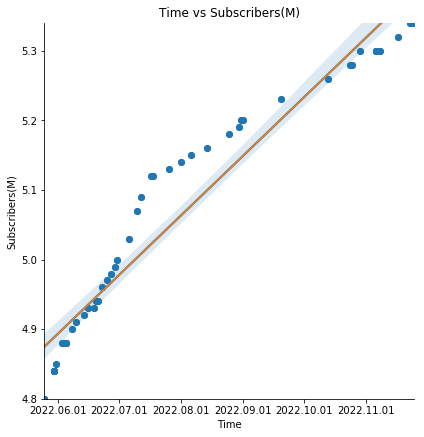

In [11]:
# Plotting
# Set publishedAtNumeric for regplot
df_sub['publishedAtNumeric'] = dates.date2num(df_sub['publishedAt'])
# Plot regression plot
sns.lmplot(x="publishedAtNumeric", y="subscriberCountMillions", data=df_sub,height=6)
plt.title('Time vs Subscribers(M)')
plt.xlabel("Time")
plt.ylabel("Subscribers(M)")
plt.xlim(df_sub['publishedAtNumeric'].min(),df_sub['publishedAtNumeric'].max())
plt.ylim(df_sub['subscriberCountMillions'].min(),df_sub['subscriberCountMillions'].max())
plt.gca().xaxis.set_major_locator(dates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y.%m.%d'))
plt.plot(x[:82],y[:82],'o')
plt.plot(x[:82],ypred[:82])



The graph above shows some linear trend in the data points.<br>
Therefore, we will create a linear model using ordinary least squares.

In [12]:
import statsmodels.api as sm

#Add the date of the creation of account and subscriber to 0 at the time
x = np.array(df_sub['toOrdinal'])
y = np.array(df_sub['subscriberCountMillions'])
x_const= sm.add_constant(x) #for constant parameter

# Fit linear regression using ols
ols_fit = sm.OLS(y,x_const).fit()

# Prediction value
ypred = ols_fit.predict(x_const)


# Summary for regression
print(ols_fit.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     656.3
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.19e-29
Time:                        23:22:30   Log-Likelihood:                 82.282
No. Observations:                  50   AIC:                            -160.6
Df Residuals:                      48   BIC:                            -156.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2044.0502     79.983    -25.556      0.0

From the OLS summary, both R-squared and adjusted R-squared are large(0.932,0.930>0.9) andd the p value is very small (<0.05). We can say that the model does not have enough evidence to be insignificant. Therefore, we will use this model for the NaN data for subscriber count.

47    4.800000
48    4.800000
49    4.800000
50    4.844049
51    4.844049
52    4.827398
53    4.824622
54    4.819072
55    4.819072
56    4.807971
57    4.802421


2038

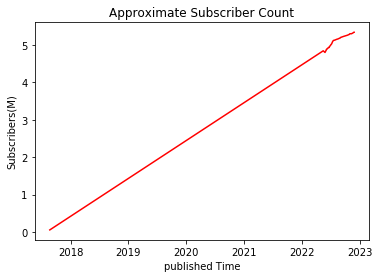

In [14]:
# Predict subscribers for empty data
def subscriberPred(x): #from ols params above
    return ols_fit.params[0] + ols_fit.params[1] *x

df_sub2=df[['publishedAt']].copy()
df_sub2['toOrdinal'] = df_sub2['publishedAt'].apply(lambda x: x.toordinal())
df_sub2 = df_sub2.drop(['publishedAt'],axis=1)
df_sub2['subscriberCountPredMillions'] = df_sub2['toOrdinal'].apply(subscriberPred)

df['subscriberCountPredMillions'] = df_sub2['subscriberCountPredMillions']
df['subscriberCountPredMillions'][:50] = df['subscriberCountMillions'][:50]
#Plot linear regression
plt.plot(df['publishedAt'],df['subscriberCountPredMillions'],color="red")
plt.title("Approximate Subscriber Count")
plt.xlabel("published Time")
plt.ylabel("Subscribers(M)")
print(df['subscriberCountPredMillions'][47:58].to_string())

# Delete sub dataframes
del df_sub
del df_sub2

gc.collect()

There is a slight discrepency in the prediction of subscribers(M) over time. Data from index 0 to 49 are real collected data where as the data after that are the predicted values. Data indexed at 49 is smaller than data indexed at 50 even though index 49 should have a larger number of subscribers. 

**Label Category** <br>
From the 'keywords' column, create columns with significant keywords.<br>
Label each video as 1 if 'keywords' include the keyword and 0 if not.
(Keywords are manually added)

In [ ]:
#Categories
keywords = ['jakun','bts','comeback','performance','stage','teaser','reaction',
    'music video', 'advertisement', 'track', 'promotion', 'recording','dance',
    'audio', 'liveperformance', 'album'] 
#unboxing = jakun + album
#dvsd = jakun + comeback

In [ ]:
# Change to all lower case for category and keywords
df['keywords']=df['keywords'].str.lower()
df['category']=df['category'].str.lower()

# Create one hot encoding for the categories
for i in keywords :
    df[i] = df.apply(lambda row: 1 if (i in row['keywords']) or (i in row['category']) else 0,axis=1)

Explanation of Keywords(Categories):
* Jakun = In-house created themed show (Travel, Cooking, Game, etc..)
* BTS = Behind the Scenes of recording album, album photoshoot, stages etc..
* comeback = Videos related to the release of new album
* performance = Videos where the K-pop band sings and/or dances
* stage = Videos where the K-pop band performed officially on stage
* teaser = teaser for music videos, movies, concerts, etc
* reaction = Video where the band films themselves watching and reacting to other videos
* music video = Music videos of songs which are not the main track (main track music videos are uploaded on another channel)
* advertisement = Videos related to the advertisements the band is doing (cosmetics, food, bank)
* track = Track videos. They are similar to music videos but usually a video for half of the track before the album releases
* promotion = Videos where the band promotes their merchandise, concert etc
* recording = Videos of the K-pop band recording their music tracks
* dance = Videos of the band dancing (stage, practice etc)
* audio = audio of the tracks of album or medley of the highlights of the full album
* liveperformance = Videos where the band performs live (doesn't necessarily have to be on a stage. Could be casual.)
* album = Anything related to their album (unboxing of album, photoshoot of album..)
Other keywords that are not included
* dvsd : comeback + jakun
* unboxing = jakun + album
* facecam, dvsd,replay,concert, game, recap, highlight medley,unboxing

# Data Analysis

In [ ]:
for i in keywords :
    print(f"Number of videos in category {i:15} : {len(df[df[i]==1]):5}")

The categories worth looking at individually are : Jakun, BTS, comeback, performance, stage, dance

**Relationship between keywords and total number of views**

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(22, 22))
for i in range(len(keywords)):
    axes[int(i/4),int(i%4)].scatter(df['viewCount'],df[keywords[i]],s=0.5)
    axes[int(i/4),int(i%4)].set_title('View vs ' +keywords[i])
    axes[int(i/4),int(i%4)].set_xlabel('number of Views')
    axes[int(i/4),int(i%4)].set_ylabel('have keyword/category' + keywords[i])


The above is a graph of 'viewCount' vs each keyword(category)<br>
The Y value is 1 for videos that contain the keywords and 0 for those that do not.
* We can see that there are only three videos over the view of 1.5+e7. These videos could be considered as an outlier in our model. However, from a business aspect, it could be analysed and interpreted as very valuable information to deterimine which videos get viral within the K-pop fandom (or even the general public) and why.
* Most of the graphs are consistent in terms of views, but some categories have videos where most of them have very small views where as a few have very large amount of views. This might be because there was something special about those videos or was included in other categories that have a higher tendency to gain more views.
* In general, we can see that the more popular videos are under categories 'Stage', 'Performance','Comeback', 'Jakun', 'Dance', 'Music Video'. The less popular videos are under the categories 'Audio', 'Teaser', 'Behind the Scenes', 'Advertisement', 'Album', 'Rection', 'Promotion'. The more vague categories are 'Track', 'Live Performance', 'Recording'.

**Relationship between duration and views for different categories**

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(22, 22))
for i in range(len(keywords)):
    df_sub = df[df[keywords[i]]==1]
    axes[int(i/4),int(i%4)].scatter(df_sub['duration'],df_sub['viewCount'])
    axes[int(i/4),int(i%4)].set_title('Duration vs View :' +keywords[i])
    axes[int(i/4),int(i%4)].set_xlabel('Length of Duration')
    axes[int(i/4),int(i%4)].set_ylabel('Views')

The above graph shows some correlation between duration and views for videos with categories 'Jakun', 'BTS, and a little bit for 'Promotion'

In [ ]:
j_corr = df[df['jakun']==1][['duration','viewCount']].corr()
bts_corr = df[df['bts']==1][['duration','viewCount']].corr()
pro_corr = df[df['promotion']==1][['duration','viewCount']].corr()
print('Jakun correlation')
print(j_corr)
print("\nBehind the Scenes correlation")
print(bts_corr)
print("\nPromotion correlation")
print(pro_corr)

* Within the category 'Jakun', views have a quite high correlation between the duration of videos - 0.71
* Within the category 'Behind the Scenes', views have moderate to low correlation with duration - 0.49
* Within the category 'Promotion', views have a weak correlation with duration - 0.22
<br>
The analysis we can make here is that the category 'Jakun' is enjoyable for more fans if they are longer. This could be because of different reasons, but generally longer 'Jakun's have a stronger theme such as the group travelling to the countryside or playing games. These videos are targeted to be watched and enjoyed similar to tv shows. Shorter 'Jakun's usually have a tendency to be promoting merchandise. The differences of the characteristics of longer and shorter 'Jakun's could be the reason for this correlation.

**Correlation between all features**

In [ ]:
df.corr()

The notable correlations here are between (viewCount, likeCount), (commentCount, viewCount). For viewCount and likeCount, it is likely for fans to press the like button if they watch a video. Therefore, as the views go up, the likes go up as well. For commentCount and viewCount, the correlation is moderate. But if we take into account that some videos are classified as children's videos and comments are not allowed, we can predict that the correlation will increase if the comments are allowed.<br>
One thing to note for likeCount and commentCount is that we cannot predict views with these prior to upload. When these data are provided, viewCount is also provided. Therefore, it is not reasonable to use these as features in the prediction model.

The correlation between subscriberCountPred and subscriberCount is 1 since we derived subscriberCountPred from subscriberCount. However, one thing to notice is that daysPassed has a negative correlation by -0.999905 with subscriberCountPred. This is because we the date for both features. <br>
The issue that arises from this is if the views of a video is more reliant on the number of subscribers the channel had when it was released or if it's more reliant on how long it has been watched from the day the data was collected. Which is the more important feature when it comes to views?

**More analysis for separate categories**

In [ ]:
df_j = df[df['jakun']==1]
corr = df_j.corr()
import seaborn as sns
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df_j=df_j.drop(['title'],axis=1)
df_j
plt.plot(df_j['viewCount'],df_j["memberCount"],'o')
plt.xlabel("Views")
plt.ylabel("Number of members of the group")

In [ ]:
# Statistical test on views and number of members in the category jakun
x = df_j['viewCount']
y = df_j['memberCount']
ols_fit = sm.OLS(y,x).fit()
print(ols_fit.params)
print(ols_fit.summary())
print(f"Correlation between viewCount and memberCount in Jakun is {x.corr(y)}")

From this graph, we can see that there is a limit on how high the views can be when a 'Jakun' video. Videos with views over 3 million are all videos with all the members(7) in it. The adjusted R squared is around 0.6, which shows some moderate effect. The correlation between the two are 0.48, which shows that there is some correlation between the two even though it is not strong.

# Data Modeling

The obstacle of creating this model is decide the prediction of views how long after they have been up. The views of a video that has been up for a day will be extremely different from the views after a month whereas the views after two months will not be very different from views after years. By comparing the data collected a month ago, the conclusion was that views don't change much after two months. So, the views prediction will be considered as views of a video two months after uploading.
<br>
The issue that might arise is that there are videos collected within two months of upload. Creating a model with these data and without these data will give a more clear idea to how important the duration of the video is and after what point duration becomes insignificant.

In [ ]:
plt.plot(df['publishedAt'],df['viewCount'],'o')
df.nlargest(10,'viewCount')

For a better generalization, considered the three videos with the highest viewCount as outliers. The video with the highest viewCount was a video that went viral to the public, which rarely happens to K-pop boyband videos. The second and third most viewed videos are a collaboration with a popular children's animation. Therefore, it attracts more views from children, which rarely happens with K-pop boy bands.

In [ ]:
df_clean = df.drop([df.index[118],df.index[153], df.index[152]],axis=0)
plt.plot(df_clean['publishedAt'],df_clean['viewCount'],'o')

**Decision Trees on Cleaned Data**

In [ ]:
from sklearn.model_selection import train_test_split
# Did not include 'duration' - after 1-2 months not significant(when compared with data collected 1-2months ago)
X = np.array(df_clean[['memberCount','daysPassed','subscriberCountPred','jakun','bts','comeback',
              'performance','stage','teaser','reaction','music video', 'advertisement', 'track',
              'promotion', 'recording','dance','audio', 'liveperformance', 'album']])
y = np.array(df_clean['viewCount'])

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=5)

#number of train & test
print(f"Shape of X_train : {X_train.shape} \nShape of X_test : {X_test.shape}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state = 42)
rf.fit(X_train,y_train)

from sklearn.metrics import r2_score, mean_squared_error
pred = rf.predict(X_test)

view_mean = df_clean['viewCount'].mean()
print(view_mean)
count = 0
for i in range(len(pred)):
    print(f"Prediction : {'%.2f' % pred[i]:10}, Real Value : {y_test[i]:8} Mean :{'%.2f' %view_mean}")##"{'%.2f' % (view_mean/y_test[i]*100):7}%")
    if abs(view_mean-y_test[i]) > abs(pred[i]-y_test[i]):
        count = count+1

print(f"{count} out of {len(pred)} has a better outcome than the mean")

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# rf = RandomForestRegressor(random_state=5)
# param_grid = {'bootstrap':[True,False],
#               'max_depth' : [10,20,30,40,50,60,70,80],
#               'max_features' : ['auto','sqrt'],
#               'min_samples_leaf' :[1,2,4,8],
#               'min_samples_split' : [2,5,10],
#               'n_estimators' : [10,100,200,400,800,1000,1200,1500,1800,2000]}

# rf_rand = RandomizedSearchCV(estimator=rf,param_distributions=param_grid,n_iter=100,cv=3,verbose=2,
#                             random_state=5,n_jobs = -1)
# rf_rand.fit(X_train, y_train)
# rf_rand.best_params_
# rand_best_model = rf_rand.best_estimator_
# rand_best_model.fit(X_train,y_train)
# print(mean_squared_error(y_test,rand_best_model.predict(X_test)))

Further work:
Analysis after getting rid of anomaly(outlier)
Better prediction model - grid search & other models & dl(but not sufficient data?)